# Descargar los datos

Los datos se unen para formar un solo dataframe que facilite su procesamiento juntando cada URL con su respectivo review

In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt 
import json 
import random
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

In [2]:
#Read the txt into a list and then into a dataframe
def read_txt(path):
    with open(path, 'r') as f:
        lines = f.readlines()
        #Delete the /usercomments part of the url and leave the rest
        lines = [re.sub('/usercomments\n', '', line) for line in lines]
    return lines

path = 'data/reviews_url.txt'

urls = read_txt(path)

urls_df = pd.DataFrame(urls, columns=['url'])

print (urls_df.head(10))

                                   url
0  http://www.imdb.com/title/tt0064354
1  http://www.imdb.com/title/tt0100680
2  http://www.imdb.com/title/tt0100680
3  http://www.imdb.com/title/tt0100680
4  http://www.imdb.com/title/tt0047200
5  http://www.imdb.com/title/tt0893406
6  http://www.imdb.com/title/tt0893406
7  http://www.imdb.com/title/tt0893406
8  http://www.imdb.com/title/tt0893406
9  http://www.imdb.com/title/tt0893406


In [3]:
#Read all files from a folder and save them in a dataframe
path = 'data/reviews/'
all_files = glob.glob(path + "/*.txt")

reviews = []

for filename in all_files:
    with open(filename, 'r') as f:
        data = f.read()
        reviews.append(data)

#Clean non alphanumeric characters in each review from the reviews list and replace them with a space
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    return text

reviews = [clean_text(review) for review in reviews]

#Create a dataframe with the reviews
reviews_df = pd.DataFrame(reviews, columns=['review'])

print(reviews_df.head(10))

                                              review
0  working with one of the best shakespeare sourc...
1  well   tremors i  the original started off in ...
2  ouch  this one was a bit painful to sit throug...
3  i ve seen some crappy movies in my life  but t...
4   carriers  follows the exploits of two guys an...
5  i had been looking forward to seeing this film...
6  effect s  without cause is generally not possi...
7  this picture started out with good intentions ...
8  i chose to see this movie because it got a goo...
9  this film has to be the worst i have ever seen...


In [4]:
#Join the dataframe with the urls and the reviews
data = pd.concat([urls_df, reviews_df], axis=1)

#Save the data to a csv file
data.to_csv('data/data.csv', index=False)

#Create a smaller file with only 30% of the data
data_smaller = data.sample(frac=0.1, random_state=42)

#Save the smaller file to a csv file
data_smaller.to_csv('data/data_smaller.csv', index=False)

print(data.head(10))

                                   url  \
0  http://www.imdb.com/title/tt0064354   
1  http://www.imdb.com/title/tt0100680   
2  http://www.imdb.com/title/tt0100680   
3  http://www.imdb.com/title/tt0100680   
4  http://www.imdb.com/title/tt0047200   
5  http://www.imdb.com/title/tt0893406   
6  http://www.imdb.com/title/tt0893406   
7  http://www.imdb.com/title/tt0893406   
8  http://www.imdb.com/title/tt0893406   
9  http://www.imdb.com/title/tt0893406   

                                              review  
0  working with one of the best shakespeare sourc...  
1  well   tremors i  the original started off in ...  
2  ouch  this one was a bit painful to sit throug...  
3  i ve seen some crappy movies in my life  but t...  
4   carriers  follows the exploits of two guys an...  
5  i had been looking forward to seeing this film...  
6  effect s  without cause is generally not possi...  
7  this picture started out with good intentions ...  
8  i chose to see this movie because it go

In [5]:
#Check that every url has a review
print(data.isnull().sum())

url       0
review    0
dtype: int64


In [6]:
#iloc is used to select rows and columns by number, in the order that they appear in the data frame
x = data.iloc[0]
x

url                     http://www.imdb.com/title/tt0064354
review    working with one of the best shakespeare sourc...
Name: 0, dtype: object

In [7]:
x['review']

'working with one of the best shakespeare sources  this film manages to be creditable to it s source  whilst still appealing to a wider audience  br    br   branagh steals the film from under fishburne s nose  and there s a talented cast on good form '

### Utilities in case of a problematic format

In [8]:
#This would be necessary in case the contents of a column contained more than a single string
#So we could join the strings into a single one

#j = json.loads(x['review'])
#j
#' '.join(''.join(jj['name'].split()) for jj in j)

In [9]:
#This too would be necessary in case the contents of a column contained more than a single string

# convert the relevant data for each movie into a single string
# to be ingested by TfidfVectorizer
def urls_and_reviews_to_string(row):
  urls = json.loads(row['url'])
  urls = ' '.join(''.join(j['name'].split()) for j in urls)

  reviews = json.loads(row['review'])
  reviews = ' '.join(''.join(j['name'].split()) for j in reviews)
  return "%s %s" % (urls, reviews)

# a) 100 random reviews sample

In [10]:
# Select a random sample of 100 reviews from the data
random_sample_df = data.sample(n=100, random_state=42)
#random_state = 42 means that the results will be the same every time we run the code

# Show the first few rows of the sample
random_sample_df.head()

,url,review
1766,http://www.imdb.com/title/tt0375560,scotty grant cramer who would go on to star ...
11919,http://www.imdb.com/title/tt0101327,this movie is complete crap avoid this waste ...
8909,http://www.imdb.com/title/tt0949379,i honestly had somewhat high expectations when...
4963,http://www.imdb.com/title/tt0845463,your first clue that this is a cheesy movie is...
10099,http://www.imdb.com/title/tt0463392,alright i got passed the horrible acting i g...


# b) Cálculo de tf,df,idf,tf-idf

### This was the first approach where only basic stopwords are considered though custom stopwords are set but not passed to the vectorizer object

The reviews are joined together in case there is more than one per url.

In [11]:
import numpy as np 
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

custom_stopwords = set(['movie', 'film', 'br', 'movies'])
all_stopwords = list(ENGLISH_STOP_WORDS.union(custom_stopwords))

#create a tf-idf vectorizer object
#max_features: build a vocabulary that only consider the top max_features ordered by term frequency across the corpus
tfidf = TfidfVectorizer(max_features=2000, stop_words='english')

# Groups the reviews by URL in case there is more than one review per URL
grouped = random_sample_df.groupby('url')['review'].apply(' '.join).reset_index()

grouped.head()

,url,review
0,http://www.imdb.com/title/tt0025173,i have never seen a movie as bad as this it i...
1,http://www.imdb.com/title/tt0028174,in this movie joe pesci slams dunks a basketb...
2,http://www.imdb.com/title/tt0028358,my comments on this movie have been deleted tw...
3,http://www.imdb.com/title/tt0035096,i rented this movie because i was browsing thr...
4,http://www.imdb.com/title/tt0065761,you have to respect this movie it may be jus...


In [12]:
# Count if there were any changes with the grouping
unique_urls_before_grouping = len(random_sample_df['url'].unique())
unique_urls_after_grouping = len(grouped['url'].unique())

# Count the number of reviews for each URL before grouping
review_count_per_url = random_sample_df['url'].value_counts()

# Show the number of unique URLs and some statistics on review counts per URL
unique_urls_before_grouping, unique_urls_after_grouping, review_count_per_url.describe()

(98,
 98,
 count    98.000000
 mean      1.020408
 std       0.142119
 min       1.000000
 25%       1.000000
 50%       1.000000
 75%       1.000000
 max       2.000000
 Name: count, dtype: float64)

In [13]:
#Print the urls with the most reviews
review_count_per_url.head(10)

url
http://www.imdb.com/title/tt0102585    2
http://www.imdb.com/title/tt0463392    2
http://www.imdb.com/title/tt0088028    1
http://www.imdb.com/title/tt0770810    1
http://www.imdb.com/title/tt0196267    1
http://www.imdb.com/title/tt0099742    1
http://www.imdb.com/title/tt0106834    1
http://www.imdb.com/title/tt0783518    1
http://www.imdb.com/title/tt0211181    1
http://www.imdb.com/title/tt0284137    1
Name: count, dtype: int64

In [14]:
#Perform the TF-IDF vectorization on the reviews
X = tfidf.fit_transform(grouped['review'])
X

<98x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 6278 stored elements in Compressed Sparse Row format>

In [15]:
#Get the feature names of the vectorized reviews. 
#Feature names are the words that make up the columns of the matrix
#get_feature_names_out() returns a numpy array 
features_x = np.array(tfidf.get_feature_names_out()) 

#Calculate the TF,DF, IDF, and TF-IDF 
tf = np.sum(X.toarray(), axis=0)   
df = np.sum(X.toarray()>0, axis=0)
#tfidf.idf_ is the inverse document frequency vector
idf = tfidf.idf_

In [16]:
# Combine the calculations into a DataFrame
tfidf_df = pd.DataFrame({'Term': features_x, 'TF': tf, 'DF': df, 'IDF': idf})
tfidf_df['TF-IDF'] = tfidf_df['TF'] * tfidf_df['IDF']

# Sort the DataFrame by TF-IDF in descending order and take the top 10 terms
top_10_tfidf = tfidf_df.sort_values('TF-IDF', ascending=False).head(10)

top_10_tfidf

,Term,TF,DF,IDF,TF-IDF
166,br,13.885431,63,1.436237,19.942766
926,movie,7.030514,60,1.484246,10.435012
521,film,5.732469,59,1.500775,8.603147
102,bad,3.539264,39,1.906240,6.746689
750,just,3.557915,44,1.788457,6.363179
808,like,3.499194,47,1.723919,6.032326
927,movies,2.352648,23,2.417066,5.686505
677,horror,1.747701,12,3.030170,5.295833
595,good,2.790123,40,1.881548,5.249750
1185,plot,2.154158,23,2.417066,5.206742


**Turns out there's in fact irrelevant words being considered, those will be considered domain specific stopwords**

Still, the results are shown for demonstration purposes

In [17]:
#Show a sample of X
X_demo = X.toarray()[:20, :40]
features_demo = features_x[:40]

X_df_demo = pd.DataFrame(X_demo, columns=features_demo)

X_df_demo

,10,100,12,13,13th,15,16,1963,2006,300,...,actually,adaptation,addict,adds,admit,adopted,adult,adults,adventures,advice
0,0.0,0.288453,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.057352,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.000000,0.000000,0.112677,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.021429,0.0,0.0
5,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
6,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
7,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
8,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
9,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0


In [18]:
# Calculate the overall TF-IDF value for each document by summing the TF-IDF values of all terms in that document
overall_tfidf_per_document = np.sum(X.toarray(), axis=1)

# Convert to DataFrame for easier viewing
overall_tfidf_df = pd.DataFrame({
    'Document': grouped['url'],
    'Overall_TFIDF': overall_tfidf_per_document
})

# Show overall TF-IDF value for a sample of the documents (e.g., the first 5)
overall_tfidf_df.head(20)


,Document,Overall_TFIDF
0,http://www.imdb.com/title/tt0025173,4.078560
1,http://www.imdb.com/title/tt0028174,6.377931
2,http://www.imdb.com/title/tt0028358,8.166236
3,http://www.imdb.com/title/tt0035096,6.375857
4,http://www.imdb.com/title/tt0065761,8.481149
5,http://www.imdb.com/title/tt0066011,3.643150
6,http://www.imdb.com/title/tt0066390,4.028576
7,http://www.imdb.com/title/tt0074802,5.468404
8,http://www.imdb.com/title/tt0075781,6.226711
9,http://www.imdb.com/title/tt0078133,7.122594


### c) tf,df,idf,tf-idf table
#### This is the best result we got from considering domain specific stopwords as part of the calculations

In [19]:
import numpy as np 
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

custom_stopwords = set(['movie', 'film', 'br', 'movies', 'seen', 'think', 'just'])
all_stopwords = list(ENGLISH_STOP_WORDS.union(custom_stopwords))


#create a tf-idf vectorizer object
#max_features: build a vocabulary that only consider the top max_features ordered by term frequency across the corpus
tfidf = TfidfVectorizer(max_features=1500, stop_words=all_stopwords)

# Groups the reviews by URL in case there is more than one review per URL
grouped = random_sample_df.groupby('url')['review'].apply(' '.join).reset_index()

#Perform the TF-IDF vectorization on the reviews
X = tfidf.fit_transform(grouped['review'])

#Get the feature names of the vectorized reviews. 
#Feature names are the words that make up the columns of the matrix
#get_feature_names_out() returns a numpy array 
features_x = np.array(tfidf.get_feature_names_out()) 

#Calculate the TF,DF, IDF, and TF-IDF 
#tf is the sum of the columns of the matrix
tf = np.sum(X.toarray(), axis=0)
#df is the sum of the columns of the matrix where the value is greater than 0
df = np.sum(X.toarray()>0, axis=0)

#tfidf.idf_ is the inverse document frequency vector implemented by sklearn
#It is calculated as log((1 + n) / (1 + df)) + 1. The +1 is to avoid division by zero
idf = tfidf.idf_

# Combine the calculations into a DataFrame
tfidf_df = pd.DataFrame({'Term': features_x, 'TF': tf, 'DF': df, 'IDF': idf})
tfidf_df['TF-IDF'] = tfidf_df['TF'] * tfidf_df['IDF']

# Sort the DataFrame by TF-IDF in descending order and take the top 10 terms
top_10_tfidf = tfidf_df.sort_values('TF-IDF', ascending=False).head(10)

top_10_tfidf

,Term,TF,DF,IDF,TF-IDF
102,bad,3.866599,39,1.906240,7.370666
784,like,3.864549,47,1.723919,6.662169
1015,plot,2.395506,23,2.417066,5.790097
574,good,3.045115,40,1.881548,5.729530
656,horror,1.888668,12,3.030170,5.722987
220,characters,2.397966,24,2.376244,5.698152
24,acting,2.194782,22,2.459626,5.398341
983,people,2.583582,33,2.068759,5.344810
376,don,2.381058,28,2.227824,5.304577
350,did,2.040582,20,2.550597,5.204703


### d) Normalization table

In [20]:
#Show a sample of X
X_demo = X.toarray()[:20, :40]
features_demo = features_x[:40]

X_df_demo = pd.DataFrame(X_demo, columns=features_demo)

X_df_demo

,10,100,12,13,13th,15,16,1963,2006,300,...,actually,adaptation,addict,adds,admit,adopted,adult,adults,adventures,advice
0,0.0,0.332783,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.067533,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.000000,0.000000,0.117691,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.021666,0.0,0.0
5,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0
6,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0
7,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0
8,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0
9,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0


In [21]:
# Calculate the overall TF-IDF value for each document by summing the TF-IDF values of all terms in that document
overall_tfidf_per_document = np.sum(X.toarray(), axis=1)

# Convert to DataFrame for easier viewing
overall_tfidf_df = pd.DataFrame({
    'Document': grouped['url'],
    'Overall_TFIDF': overall_tfidf_per_document
})

# Show overall TF-IDF value for a sample of the documents (e.g., the first 5)
overall_tfidf_df.head(20)


,Document,Overall_TFIDF
0,http://www.imdb.com/title/tt0025173,3.500592
1,http://www.imdb.com/title/tt0028174,5.834786
2,http://www.imdb.com/title/tt0028358,7.828065
3,http://www.imdb.com/title/tt0035096,6.005071
4,http://www.imdb.com/title/tt0065761,7.822882
5,http://www.imdb.com/title/tt0066011,3.415118
6,http://www.imdb.com/title/tt0066390,3.800377
7,http://www.imdb.com/title/tt0074802,5.059423
8,http://www.imdb.com/title/tt0075781,5.565953
9,http://www.imdb.com/title/tt0078133,6.602438


### Now we test the recommendations manually for the index 33

In [23]:
query = X[33]
query

<1x1500 sparse matrix of type '<class 'numpy.float64'>'
	with 25 stored elements in Compressed Sparse Row format>

In [24]:
#Print the query vector
query.toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

In [25]:
#compute similarity between query and every vector in X
scores = cosine_similarity(query, X)
scores

array([[0.03012951, 0.03996312, 0.01321677, 0.0228403 , 0.00469175,
        0.01500822, 0.        , 0.00719047, 0.02846434, 0.01092745,
        0.04033426, 0.        , 0.        , 0.04417614, 0.00222112,
        0.01573247, 0.00444738, 0.04769773, 0.00914224, 0.018428  ,
        0.        , 0.03542144, 0.03653918, 0.01562691, 0.02274349,
        0.02337301, 0.02601596, 0.03417288, 0.03525033, 0.00958283,
        0.02688457, 0.05036454, 0.01111749, 1.        , 0.        ,
        0.        , 0.00414461, 0.05932664, 0.        , 0.03646735,
        0.00373463, 0.        , 0.00844097, 0.02097408, 0.00697863,
        0.00437998, 0.03415212, 0.02386089, 0.02899015, 0.        ,
        0.01538084, 0.01196351, 0.        , 0.06431426, 0.02622406,
        0.00316732, 0.00385391, 0.01038189, 0.00870848, 0.        ,
        0.03273625, 0.        , 0.01007651, 0.01579206, 0.00758215,
        0.01101517, 0.04697358, 0.04106366, 0.03226558, 0.02659183,
        0.0087648 , 0.00712318, 0.0121009 , 0.01

In [28]:
#Get the size of the scores array
scores.shape

(1, 98)

In [30]:
# currently the array is 1 x N, make it just a 1-D array
scores = scores.flatten()
scores.shape

(98,)

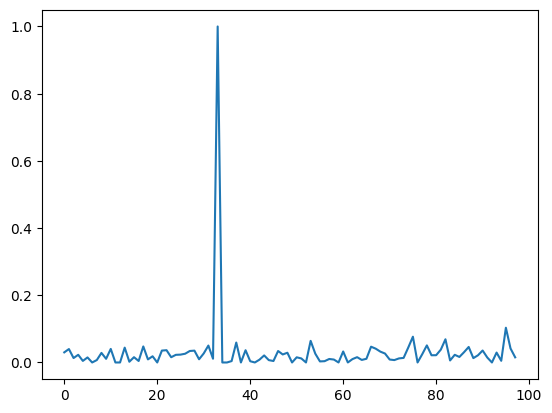

In [31]:
plt.plot(scores)

In [32]:
(-scores).argsort()

array([33, 95, 75, 82, 53, 37, 78, 31, 17, 66, 87, 74, 13, 96, 67, 10,  1,
       81, 22, 39, 90, 21, 28, 27, 46, 60, 68, 86,  0, 93, 48,  8, 30, 69,
       54, 26, 77, 47, 25,  3, 84, 24, 80, 79, 89, 43, 19, 85, 63, 15, 23,
       50, 97,  5, 91, 73,  2, 88, 72, 51, 32, 65,  9, 57, 62, 29, 18, 70,
       58, 42, 64,  7, 71, 44, 83, 94,  4, 16, 45, 36, 56, 40, 55, 14, 34,
       35, 92, 59, 38, 52, 12, 11, 76, 61, 20, 49,  6, 41])

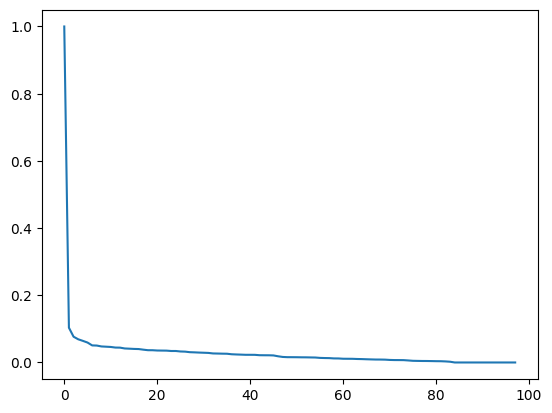

In [33]:
plt.plot(scores[(-scores).argsort()])

In [34]:
#Get the top 10 most similar reviews
top_10 = (-scores).argsort()[:10]
# The - sign is used to sort in descending order

In [35]:
#convert indices to urls
data.iloc[top_10]['url']

33    http://www.imdb.com/title/tt0127388
95    http://www.imdb.com/title/tt0272950
75    http://www.imdb.com/title/tt0277941
82    http://www.imdb.com/title/tt0760179
53    http://www.imdb.com/title/tt0220631
37    http://www.imdb.com/title/tt0080486
78    http://www.imdb.com/title/tt0182225
31    http://www.imdb.com/title/tt0127388
17    http://www.imdb.com/title/tt0277931
66    http://www.imdb.com/title/tt0277941
Name: url, dtype: object

In [36]:
#convert indices to reviews
data.iloc[top_10]['review']

33    skullduggery is a strange  strange film based ...
95    this horrendously bad piece of trash manages t...
75    some funny bits  but come bill  a film  quotin...
82    let s be honest shall we  al gore no more trul...
53    this film is overblown  predictable  pretentio...
37    minor spoilers  br    br   well i just sat up ...
78    i honestly have to say that i could not stop w...
31    this was no trainspotting or guy ritchie film ...
17    i haven t seen this    don t plan to see this ...
66    nightmare weekend is proof positive that some ...
Name: review, dtype: object

**Testing results are saved to a csv**

In [37]:
#Save indices, urls and reviews to a csv file 
with open("top_10.csv", 'w') as f:
    data.iloc[top_10].to_csv(f)

## Vòila, it works!
### Now let us create a function to replicate the results
### e) Ranking by index (because there is no title in the data)

In [41]:
#Create a function to do the same as above
def recommend(index):
    #Get the vector in the dataframe for an index
    query = X[index]
    #Compute pairwise similarity between the query vector and all the vectors in the dataframe
    scores = cosine_similarity(query, X)
    #Currently the array is 1 x N, make it just a 1-D array
    scores = scores.flatten()
    #Plot the scores
    plt.plot(scores)
    #Plot the scores in descending order
    plt.plot(scores[(-scores).argsort()])
    #Get the top 6 most similar reviews
    top_6 = (-scores).argsort()[0:7]
    #Convert indices to urls
    print(data.iloc[top_6]['url'])
    #Convert indices to reviews
    print(data.iloc[top_6]['review'])
    #Save indices, urls and reviews to a csv file
    with open("top_6_{}.csv".format(index), 'w') as f:
        data.iloc[top_6].to_csv(f,)

Recommendations for index 21:

21    http://www.imdb.com/title/tt0479948
89    http://www.imdb.com/title/tt0785025
93    http://www.imdb.com/title/tt0272950
74    http://www.imdb.com/title/tt0277941
49    http://www.imdb.com/title/tt0114366
24    http://www.imdb.com/title/tt0479948
Name: url, dtype: object
21    i should love this movie   the acting is very ...
89    this is a movie about making a movie  such mov...
93    popeye and big foot     popeye s engine compan...
74    the pallbearer is a disappointment and at time...
49    brief summary  this movie demeans everyone it ...
24    quite possibly the worst movie i ve ever seen ...
Name: review, dtype: object
None


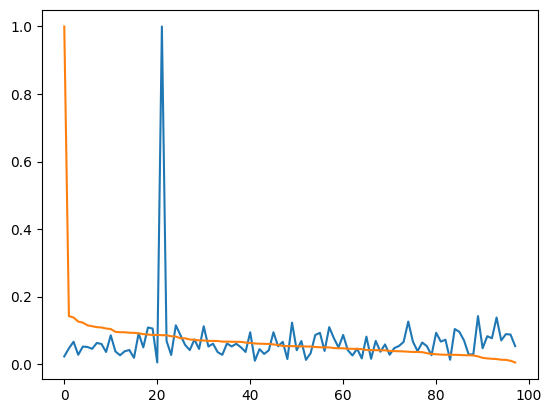

In [42]:
#Please note that the first row is the query itself
print("Recommendations for index 21:\n")
print(recommend(21))

## Finally
### f) Pairwise similarity between movies based on their reviews

In [44]:
# Calculate pairwise cosine similarity among all documents
pairwise_similarity = cosine_similarity(X)

# Convert to DataFrame for easier viewing and manipulation
pairwise_similarity_df = pd.DataFrame(pairwise_similarity, index=grouped['url'], columns=grouped['url'])

# Find the most similar pairs
most_similar_pairs = {}
for i in range(len(pairwise_similarity)):
    for j in range(i+1, len(pairwise_similarity)):
        most_similar_pairs[(grouped.iloc[i]['url'], grouped.iloc[j]['url'])] = pairwise_similarity[i, j]

# Sort the pairs
sorted_similar_pairs = sorted(most_similar_pairs.items(), key=lambda x: x[1], reverse=True)

# Convert to DataFrame and save to CSV
most_similar_df = pd.DataFrame(sorted_similar_pairs, columns=['Movie Pair', 'Cosine Similarity'])
most_similar_df['URL1'], most_similar_df['URL2'] = zip(*most_similar_df['Movie Pair'].apply(lambda x: (x[0], x[1])))
most_similar_df.drop('Movie Pair', axis=1, inplace=True)

most_similar_df.to_csv("most_similar_reviews.csv", index=False)


In [45]:
most_similar_df.head(10)

,Cosine Similarity,URL1,URL2
0,0.249462,http://www.imdb.com/title/tt0360813,http://www.imdb.com/title/tt0949379
1,0.248942,http://www.imdb.com/title/tt0311018,http://www.imdb.com/title/tt0949379
2,0.197945,http://www.imdb.com/title/tt0066390,http://www.imdb.com/title/tt0445161
3,0.168467,http://www.imdb.com/title/tt0116890,http://www.imdb.com/title/tt0923293
4,0.167933,http://www.imdb.com/title/tt0317676,http://www.imdb.com/title/tt0342882
5,0.165787,http://www.imdb.com/title/tt0291833,http://www.imdb.com/title/tt0463027
6,0.162849,http://www.imdb.com/title/tt0078133,http://www.imdb.com/title/tt0327409
7,0.152375,http://www.imdb.com/title/tt0243655,http://www.imdb.com/title/tt0469999
8,0.149912,http://www.imdb.com/title/tt0035096,http://www.imdb.com/title/tt0463027
9,0.149230,http://www.imdb.com/title/tt0338130,http://www.imdb.com/title/tt0887971
